In [499]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error , r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn import linear_model




In [443]:
data = pd.read_csv(r'F:\Datasets\airbnb_test.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 30 columns):
Id                             1000 non-null int64
price                          1000 non-null int64
host_is_superhost              998 non-null object
host_total_listings_count      998 non-null float64
host_identity_verified         998 non-null object
latitude                       1000 non-null float64
longitude                      1000 non-null float64
property_type                  1000 non-null object
room_type                      1000 non-null object
accommodates                   1000 non-null int64
bathrooms                      997 non-null float64
bedrooms                       1000 non-null int64
beds                           998 non-null float64
security_deposit               574 non-null float64
cleaning_fee                   693 non-null float64
extra_people                   1000 non-null int64
minimum_nights                 1000 non-null int64
maximum_nights  

In [444]:
total = data.isnull().sum().sort_values(ascending = False)
percent_1 = total/data.isnull().count()*100
percent_2 = ( round(percent_1,1)).sort_values(ascending= False)
missing_data = pd.concat([total,percent_2],axis=1,keys=['Total','%'])
missing_data

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,Total,%
Id,0,0.0
accommodates,0,0.0
bathrooms,3,0.3
bedrooms,0,0.0
beds,2,0.2
cancellation_policy,0,0.0
cleaning_fee,307,30.7
extra_people,0,0.0
host_identity_verified,2,0.2
host_is_superhost,2,0.2


In [445]:
data['bathrooms'] = round(data['bathrooms'])


In [446]:
data.bathrooms.isna().sum()

3

In [447]:
data.bathrooms.fillna(data.bathrooms.mode()[0],inplace=True)

In [448]:
data.host_identity_verified.isna().sum()

2

In [449]:
data.host_identity_verified.fillna(data.host_identity_verified.mode()[0],inplace=True)

In [450]:
data['bathrooms'] = data['bathrooms'].astype("int")

In [451]:
data.host_is_superhost.fillna(data.host_is_superhost.mode()[0],inplace=True)


In [452]:
category_cols = data.dtypes.pipe(lambda x : x[ x == "object"]).index.tolist()
continuous_cols = data.dtypes.pipe(lambda x : x[ x == "float"]).index.tolist()
bin_cols = data.nunique()[data.nunique() ==2 ].keys().tolist()
multi_col = [ col for col in category_cols if col not in bin_cols]
int_cols = data.dtypes.pipe(lambda x : x[ x == "int64"]).index.tolist()
int_cols.remove("price")

In [453]:
cols = ['security_deposit','host_total_listings_count','cleaning_fee','reviews_per_month' ,'accommodates','review_scores_location','beds',"review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_value","number_of_reviews"]
num_df = pd.DataFrame(data[cols])
num_df[cols] = num_df[cols].fillna(num_df.median().iloc[0])
data[cols] = num_df

# Visualization

In [454]:
data['range'] = pd.cut(data.price,bins = [data['price'].min(),100,200,300,data['price'].max()],labels = ["low","medium","high","very high"],include_lowest=True)

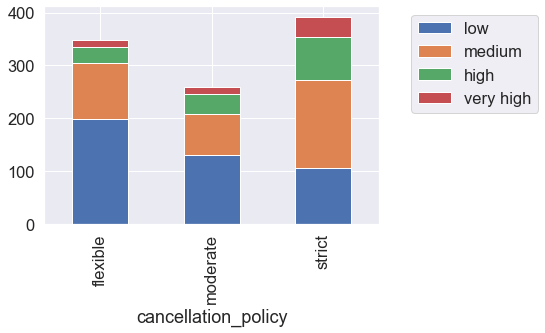

<Figure size 3240x2880 with 0 Axes>

In [455]:
pd.crosstab(data.cancellation_policy,data.range).plot.bar(stacked = True).legend(bbox_to_anchor=(1.5, 1));
plt.figure(figsize=(45,40));


It is clearly evident that there is strict cancellation policy in high-paid room and company is very strict about cancellation in those rooms.
Cancellation policy is much flexible in lower price room as company will not face much loss.

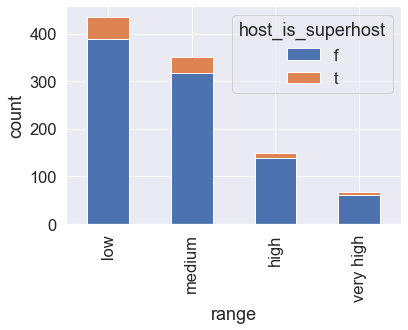

In [456]:
pd.crosstab(data.range,data.host_is_superhost).plot(kind = 'bar',stacked = 'True');
plt.ylabel('count');

No of superhost are very less and there are more no of superhost in the less price category.
So Airbnb might giving discounts to the superhost customers

No of superhost are very less and there are more no of superhost in the less price category.
So Airbnb might giving discounts to the superhost customers

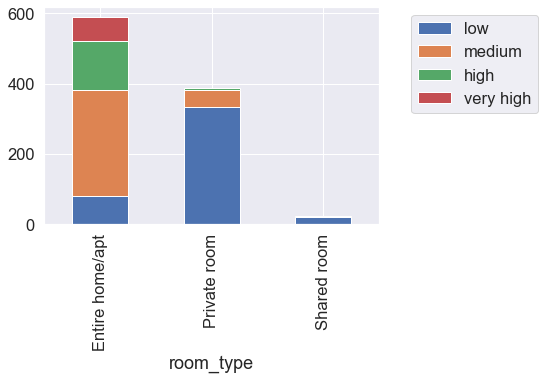

In [457]:
pd.crosstab(data.room_type,data.range).plot(kind = 'bar',stacked = 'True').legend(bbox_to_anchor=(1.5, 1));


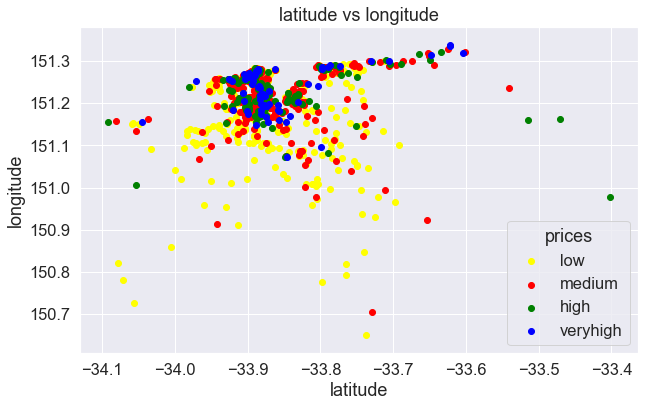

In [458]:
plt.figure(figsize=(10,6))
low = plt.scatter(data[ data['range'] =='low'].latitude,data[ data['range'] =='low'].longitude,color='yellow')
medium = plt.scatter(data[ data['range'] =='medium'].latitude,data[ data['range'] =='medium'].longitude,color='red')
high = plt.scatter(data[ data['range'] =='high'].latitude,data[ data['range'] =='high'].longitude,color='green')
veryhigh = plt.scatter(data[ data['range'] =='very high'].latitude,data[ data['range'] =='very high'].longitude,color='blue')


plt.legend(handles=(low,medium,high,veryhigh),
           labels=('low', 'medium', 'high','veryhigh'),
           title="prices")
plt.title('latitude vs longitude')
plt.xlabel("latitude")

plt.ylabel("longitude");


plt.show()

In [459]:
data.columns

Index(['Id', 'price', 'host_is_superhost', 'host_total_listings_count',
       'host_identity_verified', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'security_deposit', 'cleaning_fee', 'extra_people', 'minimum_nights',
       'maximum_nights', 'number_of_reviews', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'is_business_travel_ready', 'cancellation_policy', 'reviews_per_month',
       'range'],
      dtype='object')

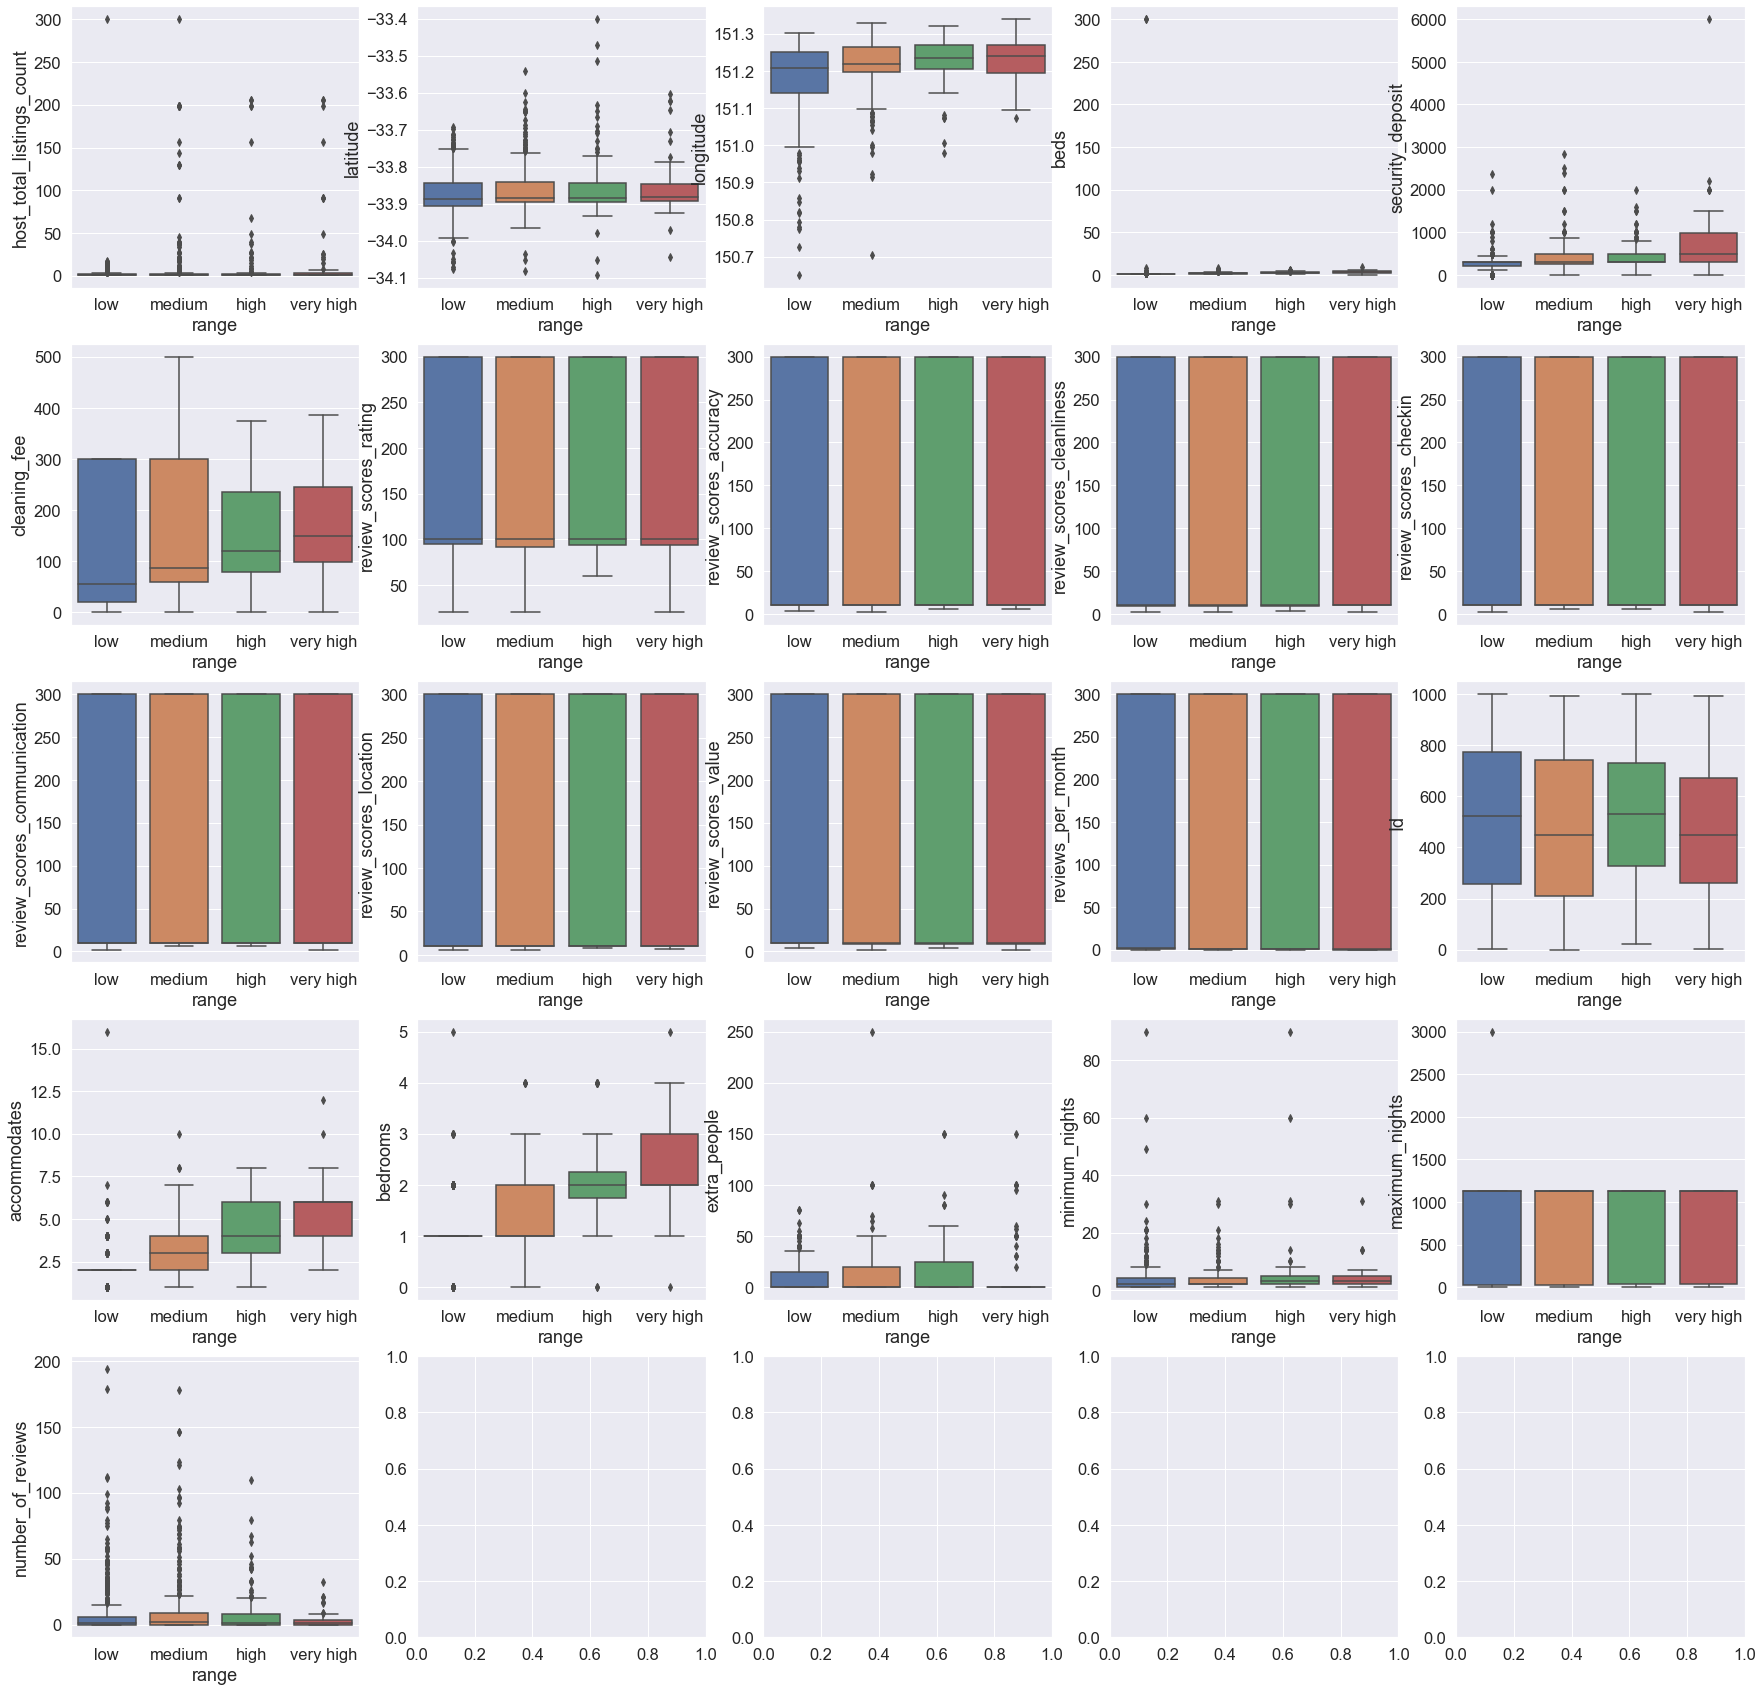

In [460]:
fig,ax = plt.subplots(5,5,figsize=(30,30))
for var , subplot in zip(continuous_cols+ int_cols,ax.flatten()):
    sns.boxplot(x = 'range',y = var,data = data,ax = subplot)

# Outlier Detection

In [461]:
data.describe()

,Id,price,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,security_deposit,...,maximum_nights,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,499.500000,145.521000,7.630000,-33.866773,151.205647,2.988000,1.27400,1.406000,2.345000,354.756000,...,693.481000,9.592000,163.593000,108.876000,108.677000,109.583000,109.294000,109.522000,109.36600,94.129380
std,288.819436,91.428523,30.194483,0.068062,0.080778,1.681869,0.50713,0.797371,13.378601,356.117155,...,534.775022,21.134526,98.291406,137.860314,138.005385,137.960597,137.863911,138.004546,138.11872,138.388182
min,0.000000,18.000000,1.000000,-34.092546,150.651014,1.000000,0.00000,0.000000,0.000000,0.000000,...,1.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,6.000000,2.00000,0.020000
25%,249.750000,75.000000,1.000000,-33.899661,151.182542,2.000000,1.00000,1.000000,1.000000,250.000000,...,30.000000,0.000000,94.000000,10.000000,9.000000,10.000000,10.000000,10.000000,9.00000,0.347500
50%,499.500000,120.000000,1.000000,-33.884990,151.217358,2.000000,1.00000,1.000000,1.000000,300.000000,...,1125.000000,2.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000,1.500000
75%,749.250000,195.750000,2.000000,-33.843008,151.261443,4.000000,2.00000,2.000000,2.000000,350.000000,...,1125.000000,7.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.00000,300.000000
max,999.000000,449.000000,300.000000,-33.401800,151.338687,16.000000,4.00000,5.000000,300.000000,6000.000000,...,3000.000000,194.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.00000,300.000000


This clearly indicates data has some outliers

In [462]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 31 columns):
Id                             1000 non-null int64
price                          1000 non-null int64
host_is_superhost              1000 non-null object
host_total_listings_count      1000 non-null float64
host_identity_verified         1000 non-null object
latitude                       1000 non-null float64
longitude                      1000 non-null float64
property_type                  1000 non-null object
room_type                      1000 non-null object
accommodates                   1000 non-null int64
bathrooms                      1000 non-null int32
bedrooms                       1000 non-null int64
beds                           1000 non-null float64
security_deposit               1000 non-null float64
cleaning_fee                   1000 non-null float64
extra_people                   1000 non-null int64
minimum_nights                 1000 non-null int64
maximum_nig

In [463]:
for i in continuous_cols:
    q75 , q25 = np.percentile(data.loc[:,i],[75,25])
    iqr = q75 - q25
    minn = q25 - 1.5*iqr
    maxx = q75 + 1.5*iqr
    print("col name",i)
    print("min value",minn)
    print("max value ",maxx)
    print(" outlier in {var} are ".format( var = i))
    print("outliers are ",(data.loc[ data.loc[:,i] < minn , i].count() +  data.loc[data.loc[:,i] > maxx, i].count()))
    #  data.loc[ data[:,i] > maxx,i].count()
    #print("and ",data.loc[ data.loc[:,i] > maxx])
    print("+++++++++")

col name host_total_listings_count
min value -0.5
max value  3.5
 outlier in host_total_listings_count are 
outliers are  142
+++++++++
col name latitude
min value -33.98463988000001
max value  -33.75802941999999
 outlier in latitude are 
outliers are  91
+++++++++
col name longitude
min value 151.0641916749999
max value  151.37979327500005
 outlier in longitude are 
outliers are  51
+++++++++
col name beds
min value -0.5
max value  3.5
 outlier in beds are 
outliers are  85
+++++++++
col name security_deposit
min value 100.0
max value  500.0
 outlier in security_deposit are 
outliers are  203
+++++++++
col name cleaning_fee
min value -326.25
max value  675.75
 outlier in cleaning_fee are 
outliers are  0
+++++++++
col name review_scores_rating
min value -215.0
max value  609.0
 outlier in review_scores_rating are 
outliers are  0
+++++++++
col name review_scores_accuracy
min value -425.0
max value  735.0
 outlier in review_scores_accuracy are 
outliers are  0
+++++++++
col name review

Total 500 entries are coming into outliers so we will take those as business outliers and will not remove those

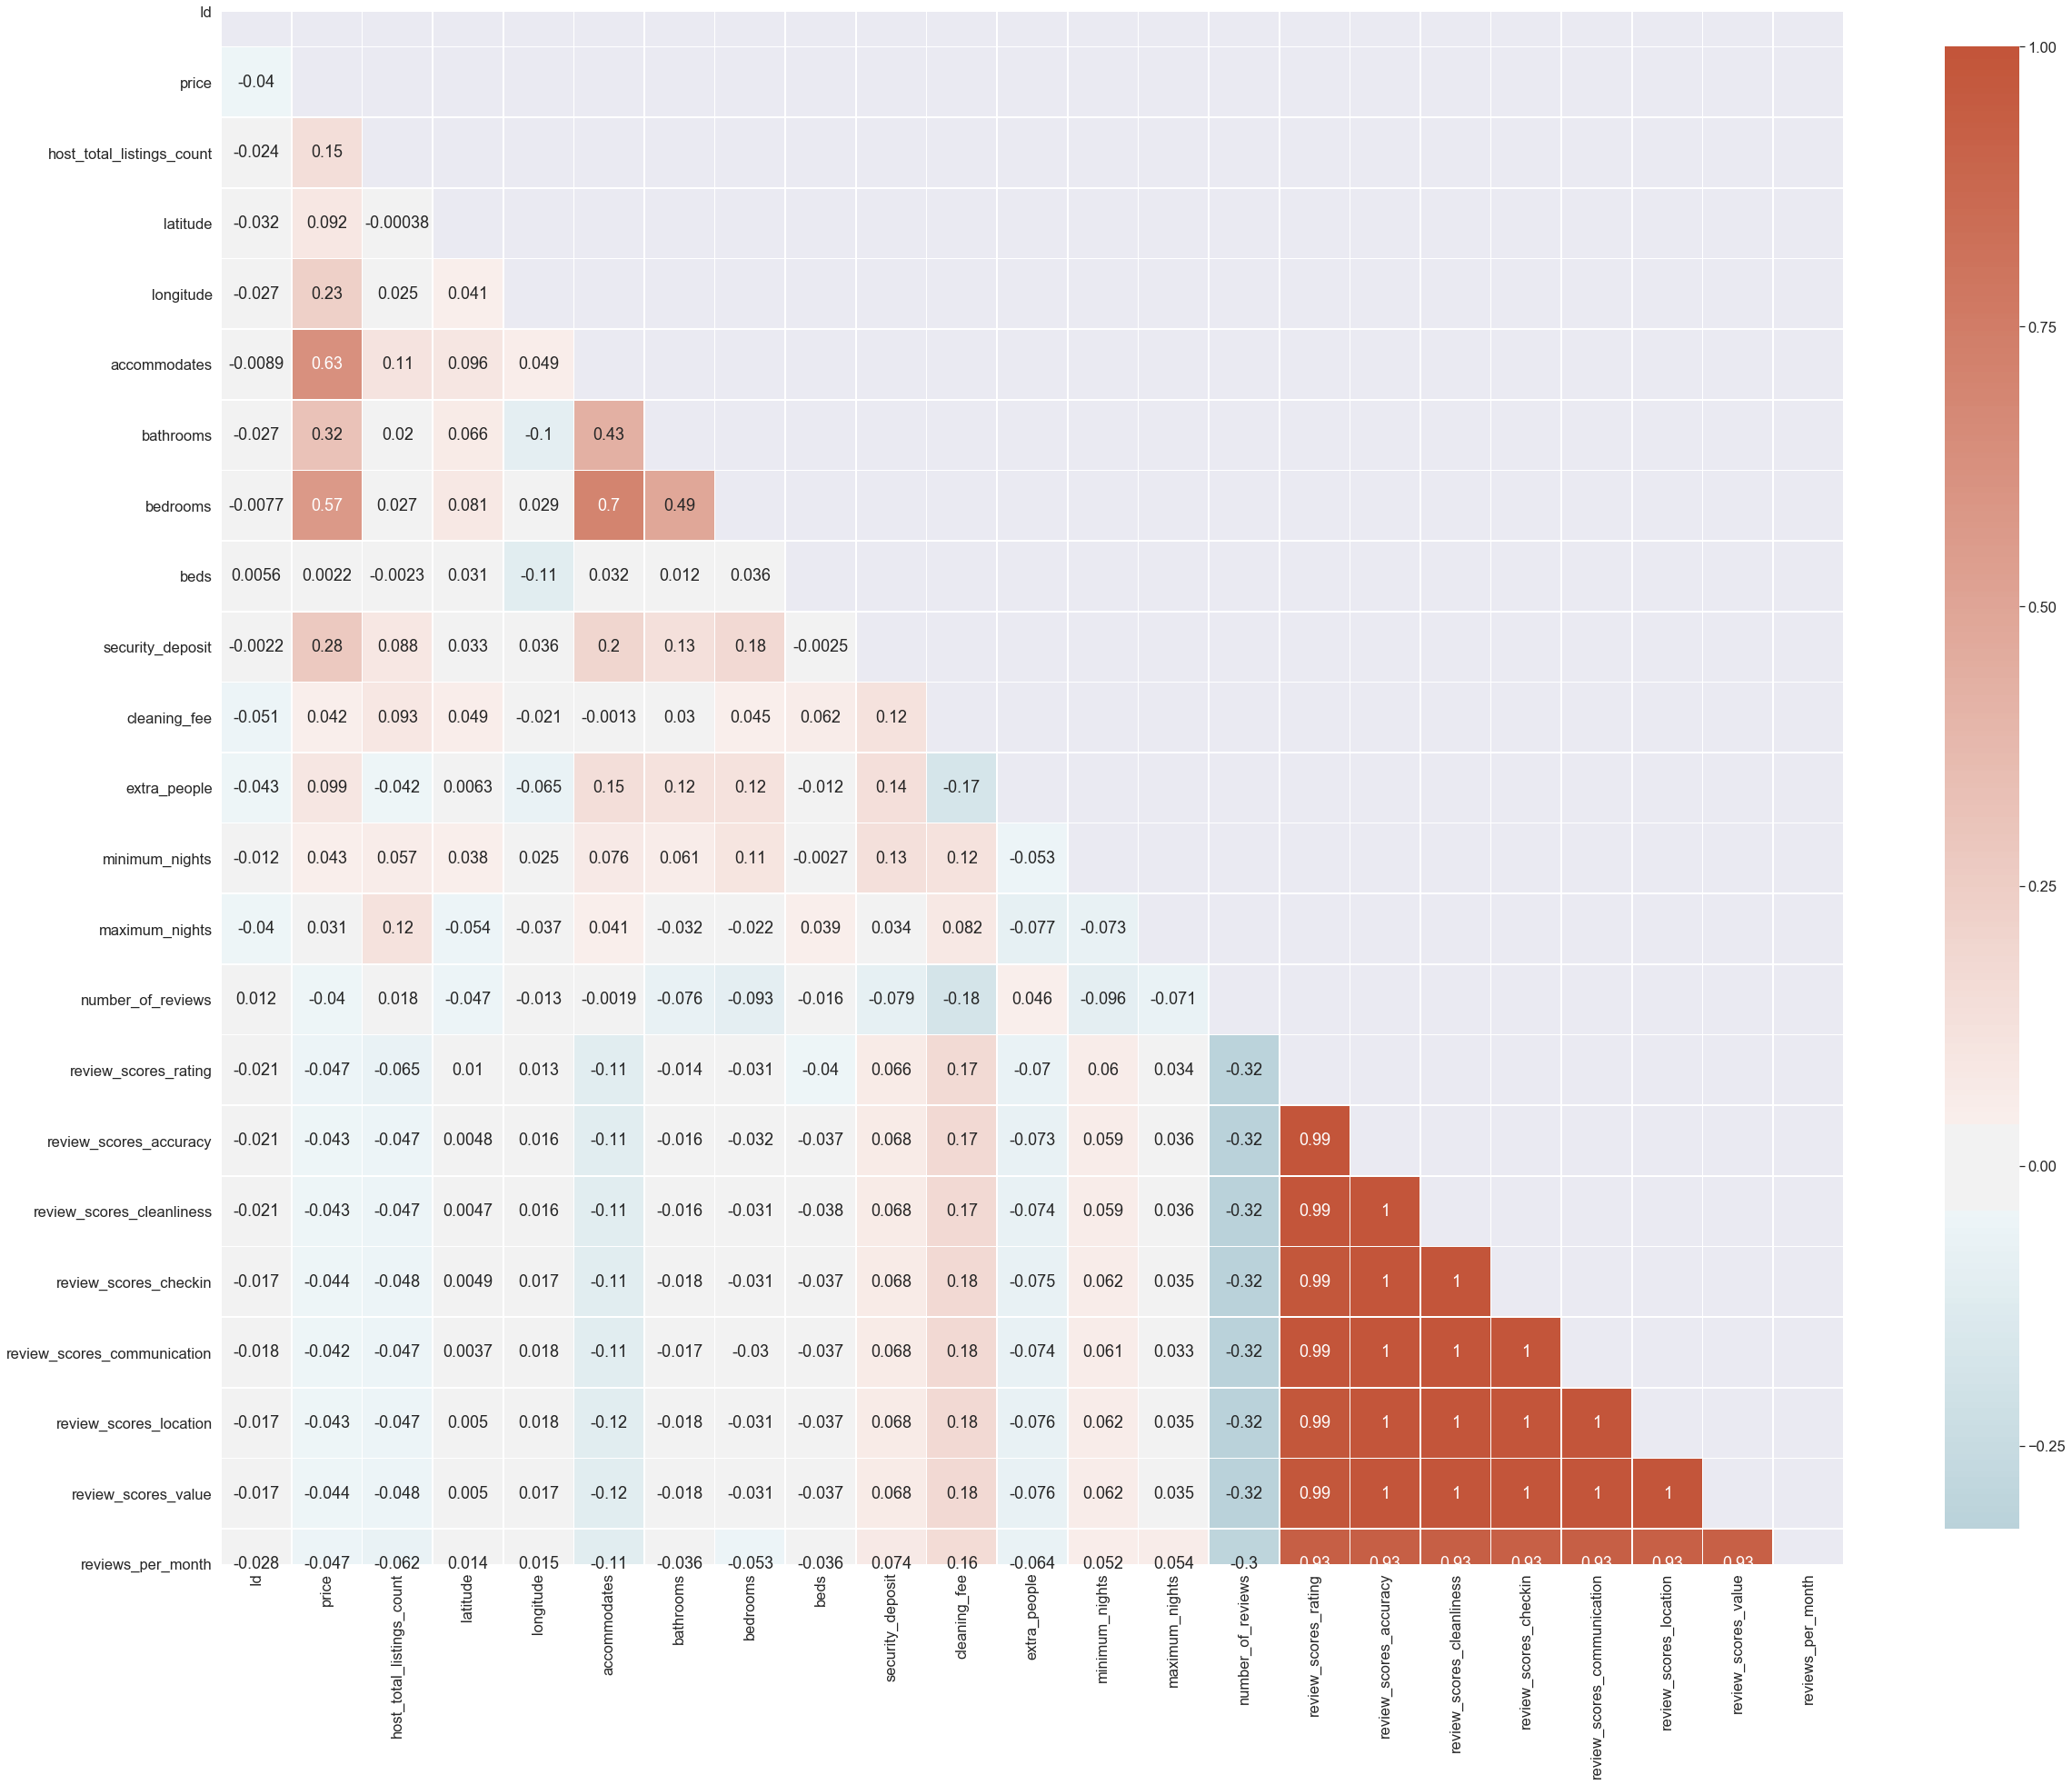

In [464]:
corr = data.corr()
mask = np.zeros_like(corr, dtype=np.bool)
# Creating mask for the upper right triangle
mask[np.triu_indices_from(mask)] = True
fig,ax = plt.subplots(figsize=(40,50))
cmap = sns.diverging_palette(220,20,as_cmap=True)
sns.heatmap(corr,mask=mask,cmap=cmap,vmax=1,center=0,square=True, linewidth=.6,cbar_kws={"shrink":.6},annot = True);


In [465]:
data.drop(["beds","review_scores_rating","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_value","number_of_reviews"],axis=1,inplace=True)

In [466]:
data.describe()

,Id,price,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,security_deposit,cleaning_fee,extra_people,minimum_nights,maximum_nights,review_scores_location,reviews_per_month
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,499.500000,145.521000,7.630000,-33.866773,151.205647,2.988000,1.27400,1.406000,354.756000,144.19700,10.85600,3.807000,693.481000,109.522000,94.129380
std,288.819436,91.428523,30.194483,0.068062,0.080778,1.681869,0.50713,0.797371,356.117155,117.90755,21.09688,6.098274,534.775022,138.004546,138.388182
min,0.000000,18.000000,1.000000,-34.092546,150.651014,1.000000,0.00000,0.000000,0.000000,0.00000,0.00000,1.000000,1.000000,6.000000,0.020000
25%,249.750000,75.000000,1.000000,-33.899661,151.182542,2.000000,1.00000,1.000000,250.000000,49.50000,0.00000,1.000000,30.000000,10.000000,0.347500
50%,499.500000,120.000000,1.000000,-33.884990,151.217358,2.000000,1.00000,1.000000,300.000000,100.00000,0.00000,2.000000,1125.000000,10.000000,1.500000
75%,749.250000,195.750000,2.000000,-33.843008,151.261443,4.000000,2.00000,2.000000,350.000000,300.00000,20.00000,4.000000,1125.000000,300.000000,300.000000
max,999.000000,449.000000,300.000000,-33.401800,151.338687,16.000000,4.00000,5.000000,6000.000000,500.00000,250.00000,90.000000,3000.000000,300.000000,300.000000


In [467]:
data.columns

Index(['Id', 'price', 'host_is_superhost', 'host_total_listings_count',
       'host_identity_verified', 'latitude', 'longitude', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'security_deposit', 'cleaning_fee', 'extra_people', 'minimum_nights',
       'maximum_nights', 'review_scores_location', 'instant_bookable',
       'is_business_travel_ready', 'cancellation_policy', 'reviews_per_month',
       'range'],
      dtype='object')

In [468]:
le = LabelEncoder()
for cols in data.columns:
    if cols in multi_col:
        print('multi col',cols)
        data[cols] = le.fit_transform(data[cols].astype('str'))
    else:
        data[cols] = le.fit_transform(data[cols])

multi col property_type
multi col room_type
multi col cancellation_policy


Changing property_type to 3 category variable

In [469]:
n = data['property_type'].value_counts().index[:2]
data['property_type'] = data.property_type.where(data.property_type.isin(n),'other')

In [470]:
data['property_type'].value_counts()

0        651
11       254
other     95
Name: property_type, dtype: int64

convert categorical to neumerical col

In [471]:
data = pd.get_dummies(data = data,columns =multi_col)

In [472]:
new_data = data.copy()
out = data[['price']].copy()
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 29 columns):
Id                           1000 non-null int64
price                        1000 non-null int64
host_is_superhost            1000 non-null int32
host_total_listings_count    1000 non-null int64
host_identity_verified       1000 non-null int32
latitude                     1000 non-null int64
longitude                    1000 non-null int64
accommodates                 1000 non-null int64
bathrooms                    1000 non-null int64
bedrooms                     1000 non-null int64
security_deposit             1000 non-null int64
cleaning_fee                 1000 non-null int64
extra_people                 1000 non-null int64
minimum_nights               1000 non-null int64
maximum_nights               1000 non-null int64
review_scores_location       1000 non-null int64
instant_bookable             1000 non-null int32
is_business_travel_ready     1000 non-null int32
reviews_per_

In [473]:
new_data.drop(['price','range'],axis = 1,inplace=True)

In [474]:

X = sm.add_constant(new_data) # adding a constant

lr_model = sm.OLS(out,X).fit()
predictions = lr_model.predict(X)

print_model = lr_model.summary()
print(print_model)



                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     75.92
Date:                Wed, 08 Apr 2020   Prob (F-statistic):          7.24e-204
Time:                        23:40:13   Log-Likelihood:                -4632.3
No. Observations:                1000   AIC:                             9315.
Df Residuals:                     975   BIC:                             9437.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [475]:
new_data.drop(['host_identity_verified','host_is_superhost','Id','maximum_nights','reviews_per_month'],axis=1,inplace=True)

In [476]:
X = sm.add_constant(new_data) # adding a constant

lr_model = sm.OLS(out,X).fit()
predictions = lr_model.predict(X)

print_model = lr_model.summary()
print(print_model)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.644
Method:                 Least Squares   F-statistic:                     96.09
Date:                Wed, 08 Apr 2020   Prob (F-statistic):          2.50e-208
Time:                        23:40:13   Log-Likelihood:                -4633.3
No. Observations:                1000   AIC:                             9307.
Df Residuals:                     980   BIC:                             9405.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

In [477]:
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
host_total_listings_count    1000 non-null int64
latitude                     1000 non-null int64
longitude                    1000 non-null int64
accommodates                 1000 non-null int64
bathrooms                    1000 non-null int64
bedrooms                     1000 non-null int64
security_deposit             1000 non-null int64
cleaning_fee                 1000 non-null int64
extra_people                 1000 non-null int64
minimum_nights               1000 non-null int64
review_scores_location       1000 non-null int64
instant_bookable             1000 non-null int32
is_business_travel_ready     1000 non-null int32
property_type_0              1000 non-null uint8
property_type_11             1000 non-null uint8
property_type_other          1000 non-null uint8
room_type_0                  1000 non-null uint8
room_type_1                  1000 non-null uint8
room_type_2 

In [478]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(new_data.values,i) for i in range(new_data.shape[1])]
vif["features"] = new_data.columns

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [479]:
vif

,VIF Factor,features
0,1.159483,host_total_listings_count
1,1.033197,latitude
2,1.158606,longitude
3,2.854043,accommodates
4,1.442559,bathrooms
5,2.435841,bedrooms
6,1.206104,security_deposit
7,1.245182,cleaning_fee
8,1.088815,extra_people
9,1.102049,minimum_nights


In [480]:
new_data.columns

Index(['host_total_listings_count', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'security_deposit', 'cleaning_fee',
       'extra_people', 'minimum_nights', 'review_scores_location',
       'instant_bookable', 'is_business_travel_ready', 'property_type_0',
       'property_type_11', 'property_type_other', 'room_type_0', 'room_type_1',
       'room_type_2', 'cancellation_policy_0', 'cancellation_policy_1',
       'cancellation_policy_2'],
      dtype='object')

In [481]:
int_cols.remove("number_of_reviews")

In [482]:
int_cols.remove("Id")
int_cols.remove("maximum_nights")
int_cols.remove("minimum_nights")

In [483]:
stdscalar = StandardScaler()

del_cols = ["beds","review_scores_rating","longitude","latitude","review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_value","number_of_reviews","Id",'reviews_per_month','maximum_nights']
cols = list ( set( continuous_cols) - set(del_cols))
cols.extend(int_cols)
#print(cols)
#for columns in cols:
#    new_data[columns] = np.log(data[columns] + 0.1) 
new_data[cols] = stdscalar.fit_transform(new_data[cols].values)



In [484]:
cols_name = [i for i in new_data.columns ]
X = new_data[cols_name]
Y = out

In [485]:

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


In [486]:
X_oll = sm.add_constant(X_train) # adding a constant

lr_model = sm.OLS(Y_train,X_oll).fit()
predictions = lr_model.predict(X_oll)

print_model = lr_model.summary()
print(print_model)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.655
Method:                 Least Squares   F-statistic:                     80.88
Date:                Wed, 08 Apr 2020   Prob (F-statistic):          1.23e-169
Time:                        23:40:15   Log-Likelihood:                -3704.5
No. Observations:                 800   AIC:                             7449.
Df Residuals:                     780   BIC:                             7543.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [510]:
scores = []
best_svr = RandomForestRegressor(n_estimators=10,min_samples_leaf=7,max_depth=10,ccp_alpha=0.8)
kf = KFold(n_splits=20)
for train_index, test_index in kf.split(X):
    #print("Train Index: ", train_index, "\n")
    #print("Test Index: ", test_index)

    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], Y.iloc[train_index], Y.iloc[test_index]
    best_model = best_svr.fit(X_train, y_train)
    print('best test score',best_svr.score(X_test,y_test))
    scores.append(best_svr.score(X_test, y_test))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__m

best test score 0.7459102934056803
best test score 0.4543651123101903
best test score 0.7349267414900652
best test score 0.5499504354251944
best test score 0.6666092435912616


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__m

best test score 0.5923045823210032
best test score 0.6223839037204468
best test score 0.6317001588729405
best test score 0.5920907322924309
best test score 0.5521508359790563
best test score 0.5447225734010477


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__m

best test score 0.8651129333622415
best test score 0.6528362810298378
best test score 0.6648314316751278
best test score 0.5519672436884874
best test score 0.7111139885264124
best test score 0.7387492523593622
best test score 0.5338016509514052
best test score 0.5867462167156747
best test score 0.6335320357749047


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__m

In [511]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


In [512]:
print ( 'train score ',best_svr.score(X_train,Y_train))
print ( 'test score ',best_svr.score(X_test,Y_test))


train score  0.7751500810261004
test score  0.7504824708990101


In [513]:
pred = best_svr.predict(X_train)
rmse = (np.sqrt(mean_squared_error(Y_train,pred)))
print("Root Mean Square Error train  : ", rmse)
pred = best_svr.predict(X_test)
rmse = (np.sqrt(mean_squared_error(Y_test,pred)))
print("Root Mean Square Error test  : ", rmse)


Root Mean Square Error train  :  20.2836020754588
Root Mean Square Error test  :  19.57154344303119


In [514]:
best_svr.score(new_data,out)

0.7712039779043858